## Trying to replicate Berg et al, 2003. Assesment of textural variation in laminated sands with computer vision

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt


## Plotting image

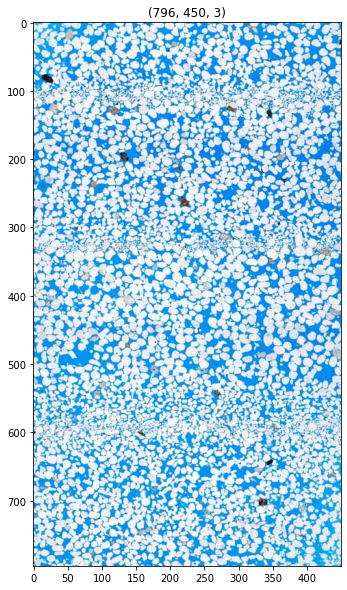

In [11]:
img = cv2.imread("sandLaminated.jpg", cv2.COLOR_BGR2RGB)

def plotRGB(img):
    plt.rcParams["figure.figsize"] = (20,10)
    imgrgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)    
    plt.imshow(imgrgb)
    plt.title(imgrgb.shape)
    

plotRGB(img)



## Apply fast Means Denoising

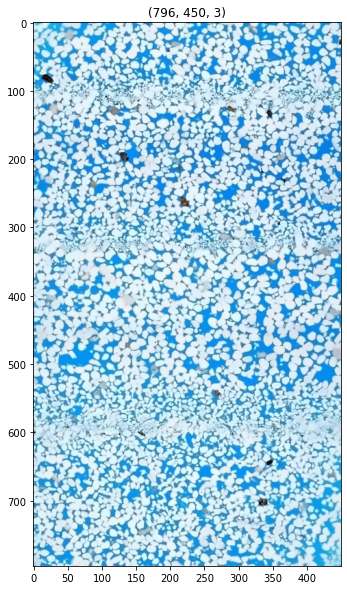

In [3]:
dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

plotRGB(dst)

In [4]:
import pandas as pd
from sklearn.cluster import KMeans

def quantize_image(img, n_clusters):
    """
    Agrupa los pixeles en una imagen y regresa la imagen cuantizada
    
    img - 3D numpy array
    n_clusters - numero de clusters o colores en la imagen final 
    
    """
    
    img = np.array(img, dtype=np.float64)/255 # se normaliza
    
    m,l,k = img.shape[0],img.shape[1], img.shape[2] # redimesionando los datos
    df = pd.DataFrame(img.reshape(m*l, k))
    df.columns = ["R", "G", "B"]
    
    
    kmeans = KMeans(n_clusters= n_clusters)
    
    kmeans.fit(df.sample(5000))
    
    df["clusters"]= kmeans.predict(df)
    
    centers = pd.DataFrame(kmeans.cluster_centers_)
    
    centers["clusters"] = range(n_clusters)
    
    
    df["ind"] = df.index
    df = df.merge(centers)
    df = df.sort_values("ind")
    df = df.drop("ind", 1)
    
    quant_img = df.iloc[:,4:7].values

    quant_img = quant_img.reshape(img.shape[0], img.shape[1], img.shape[2])
    
    #quant_img = quant_img*255
    
    quant_img = np.array(quant_img, dtype=np.float64)
    

    return quant_img


## Quantize image with 2 clusters (white for grains, blue for pores)

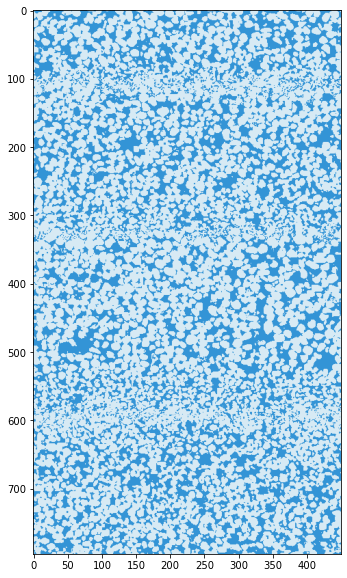

In [13]:
quantIMG = quantize_image(img[:,:,::-1], n_clusters=2)
plt.imshow(quantIMG)

## Binarize image

<ipython-input-14-9f5736de125b>:3: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (796, 450, 3) looks like an RGB image
  ret1,th1 = cv2.threshold(quantIMG,threshold_otsu(quantIMG),255,cv2.THRESH_BINARY)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


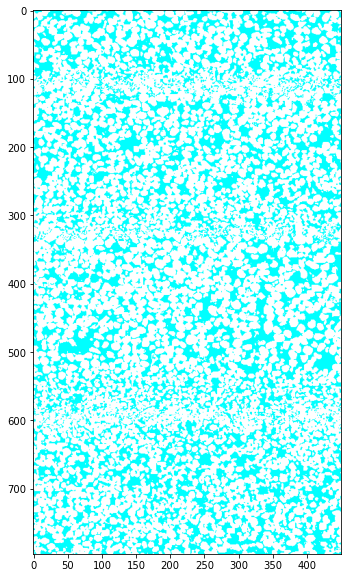

In [14]:
from skimage.filters import threshold_otsu
# ret1,th1 = cv2.threshold(quantIMG,0.8,255,cv2.THRESH_BINARY)
ret1,th1 = cv2.threshold(quantIMG,threshold_otsu(quantIMG),255,cv2.THRESH_BINARY)

plt.imshow(th1)

## Trying to count grains (experiment)

In [15]:
from scipy import ndimage
from skimage import measure, color, io
import cv2

def doClusterQT(imgCon):
    kernel = np.ones((3,3), np.uint8)
    eroded = cv2.erode(imgCon, kernel, iterations=1)
    dilated = cv2.dilate(eroded, kernel, iterations=1)
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(dilated,-1,kernel)
    blur = cv2.GaussianBlur(dilated,(5,5),0)
    
    mask = blur == 255
    
    s = [[1,1,1], [1,1,1], [1,1,1]]

    labeled_mask, num_labels = ndimage.label(mask[:,:,0], structure=s)
    img = color.label2rgb(labeled_mask, bg_label=0)
    
    clusters = measure.regionprops(labeled_mask, imgCon[:,:,0])
    
    return len(clusters), img  
    
def doClusterQT2(imgCon):
    
    kernel = np.ones((3,3), np.uint8)
    eroded = cv2.erode(imgCon,kernel,iterations = 1)
    dilated = cv2.dilate(eroded,kernel,iterations = 1)
    canny = cv2.Canny(dilated, 10,50) 
    kernel = np.ones((3,3),np.float32)/25
    dst = cv2.filter2D(dilated,-1,kernel)
    blur = cv2.GaussianBlur(dilated,(5,5),0)
    
    mask = canny == 255
    
    s = [[1,1,1], [1,1,1], [1,1,1]]
    
    labeled_mask, num_labels = ndimage.label(mask, structure=s)
    img2 = color.label2rgb(labeled_mask, bg_label=0)
    print(labeled_mask.shape, imgCon.shape)
    clusters = measure.regionprops(labeled_mask, imgCon[:,:,0])
    
    
    
    
    
    
    return len(clusters), img2  

(796, 450) (796, 450, 3)


Text(0.5, 1.0, '3147')

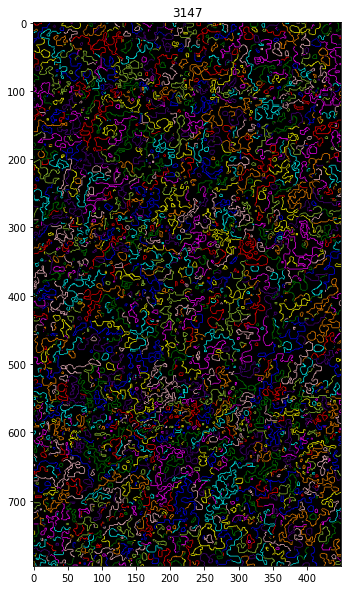

In [16]:

imgINT= np.uint8(th1)
clusters, imagen = doClusterQT2(imgINT)

plt.imshow(imagen)
plt.title(clusters)

In [39]:
def make_histogram_img(img):
    """go row by row in y direction of image given in img, and count pixels with 255 values and add them, then show a histogram of count of pixels with 255 value in image y - axis."""
    hist = []

    for i in range(img.shape[0]):
        hist.append(len(np.where(img[i,:] == 255)[0]))
    plt.figure(figsize=(3, 12))
    plt.plot(hist, range(len(hist)))
    plt.title("Number of voids pixels across section")
    plt.show()

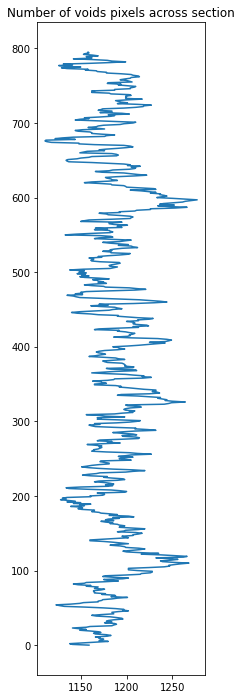

In [40]:

make_histogram_img(th1)